# Prepare notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from wordcloud import WordCloud
from plotting_utilities import *

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acraig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data

In [3]:
books = pd.read_pickle('2019112_goodreads_book_data.pkl')

In [4]:
len(books)

610

In [5]:
books.goodreads_author_bio.count()

439

# Prepare textual data

In [6]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['filtered_author_bio'] = books.goodreads_author_bio.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                 if token not in stop_words
                                                               ]))


<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<ipython-input-6-0d2d354b2431>:1: DeprecationWarning: invalid escape sequence \W
  alphanumeric_filter = re.compile('[\W_]+')


In [7]:
books['filtered_doc_length'] = books.filtered_author_bio.map(lambda text: len(text.split(' ')))

 # Visualization

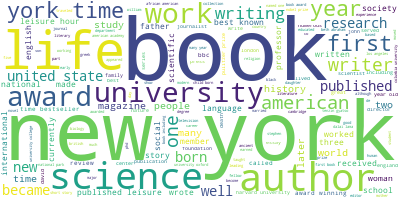

In [8]:
# Generate a word cloud based on all author_bios
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(','.join(list(books.filtered_author_bio.values)))
wordcloud.to_image()

# Word counting methods

In [10]:
max_df=0.90
min_df=4
max_features=2000


### Bag of words

In [11]:
# Fit and transform the author_bios
word_bag_cv = CountVectorizer(ngram_range=(1,1), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
word_bag_counts = word_bag_cv.fit_transform(books.filtered_author_bio)

# Check against visualization
n = 5
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['author', 'time', 'book', 'new', 'university']

### Bag of bigrams

In [12]:
# Fit and transform the author_bios
bigram_bag_cv = CountVectorizer(ngram_range=(2,2), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
bigram_bag_counts = bigram_bag_cv .fit_transform(books.filtered_author_bio)

# Check against visualization
n = 5
counts = bigram_bag_counts.toarray().sum(axis = 0)
bigrams = bigram_bag_cv.get_feature_names()
[bigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['published leisure', 'leisure hour', 'york time', 'united state', 'new york']

### Bag of trigrams

In [13]:
# Fit and transform the author_bios
trigram_bag_cv = CountVectorizer(ngram_range=(3,3), max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english')
trigram_bag_counts = trigram_bag_cv.fit_transform(books.filtered_author_bio)

# Check against visualization
n = 5
counts = trigram_bag_counts.toarray().sum(axis = 0)
trigrams = trigram_bag_cv.get_feature_names()
[trigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['new york city',
 'american academy art',
 'york time bestseller',
 'published leisure hour',
 'new york time']

### TF-IDF 

In [14]:
tfidf_v = TfidfVectorizer(use_idf=True, max_df=max_df, min_df=min_df, 
                              max_features=max_features,stop_words='english' )
tfidf_weights = tfidf_v.fit_transform(books.filtered_author_bio)

# Check against visualization
n = 10
weights = tfidf_weights.toarray().sum(axis = 0)
weighted_words = tfidf_v.get_feature_names()
[weighted_words[i] for i in np.argpartition(weights, -n)[-n:]] 

['science',
 'life',
 'york',
 'american',
 'professor',
 'new',
 'time',
 'author',
 'book',
 'university']

# Topic Modeling

In [15]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [16]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 20

def print_top_words(model, feature_names, n_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        message = " Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [17]:
# Fit the NMF model (Frobenius norm)
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (Frobenius norm):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (Frobenius norm):
 Topic #0: book american award life author science writer prize novel work
 Topic #1: leisure hour published october sketch isabella lucy 1883 hebrides hawaiian
 Topic #2: university professor research biology science harvard oxford department psychology college
 Topic #3: thích hạnh nhất vietnamese monk dharma bảo novitiate monastery thiền
 Topic #4: new york time book bestseller magazine author award best washington
 Topic #5: winchester simon scandal bloody appear watergate resides obe broadcaster dozen
 Topic #6: sack abraham beth college music medicine university art neurologist awakening
 Topic #7: history military medieval jerusalem specialized hebrew historical current 2002 relation
 Topic #8: wohlleben bonn forester peter ecological theme 1964 german writes language
 Topic #9: autism diagnosed grandin labeled darkness humming autistic groping screaming stunned
 Topic #10: obama president barack state law chicago united african illinois se

In [18]:
# Fit the NMF model (generalized Kullback-Leibler divergence)
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (generalized Kullback-Leibler divergence):
 Topic #0: award time book national new work american author appeared magazine
 Topic #1: nineteenth englishwoman english lady traveller review century novel notable golden
 Topic #2: university professor biology director science department fellow study society college
 Topic #3: born thích poet known teacher author thiền life studied family
 Topic #4: new york time life bestseller school harvard medicine mind city
 Topic #5: nonfiction book british numerous journalist born publication article college london
 Topic #6: employed robert birthday award columbia blitz support parent white north
 Topic #7: book history writer science work france world field development worked
 Topic #8: author born language best book german popular known theme time
 Topic #9: story book year family david old collection parent tell novel
 Topic #10: important father state school united following child graduated family people
 Topic #11: book lif

In [19]:
# Fit LDA model 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(word_bag_counts)
print("\nTopics in LDA model:")
print_top_words(lda, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: book university new time life author science york year professor
 Topic #1: american known born maya author angelou novel figure book prize
 Topic #2: university new center york cancer physician time medicine published professor
 Topic #3: jonathan award emmy 1976 series surgery 35 dame honorary nominated
 Topic #4: got johnson good new author including book life bad brooklyn
 Topic #5: beard classic cambridge college time mary professor university supplement 1955
 Topic #6: war school father parent story old later year teacher born
 Topic #7: thích nhất hạnh france vietnamese monk poet born author joined
 Topic #8: center greater brain expedition book thing include party program language
 Topic #9: series jonathan penguin queer emmy award television eye star winning
 Topic #10: obama president state tibetan lama united peace african born law
 Topic #11: mcgill run worked written university journal engineer scientific billboard grammy
 Topic #12: expedi

In [21]:


lda_data =  pyLDAvis.prepare(topic_term_dists = lda.components_, 
                             doc_topic_dists = lda.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
from sklearn.metrics import log_loss, make_scorer, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [24]:
def custom_scorer_highest_topic_silhouette(estimator, X):
    X = X.toarray()
    return silhouette_score(X, np.argmax(estimator.transform(X), axis =1))
  
def custom_scorer_highest_topic_calinski_harabasz(estimator, X):
    X = X.toarray()
    return calinski_harabasz_score(X, np.argmax(estimator.transform(X), axis =1))


def custom_scorer_kmeans_silhouette(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return silhouette_score(X, labels)
  
def custom_scorer_kmeans_calinski_harabasz(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return calinski_harabasz_score(X, labels)

def custom_scorer_log_likelihood(estimator, X):
    X = X.toarray()
    return estimator.score(X)

def custom_scorer_negative_perplexity(estimator, X):
    X = X.toarray()
    return -1*estimator.perplexity(X)

In [ ]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           'log_likelihood': custom_scorer_log_likelihood,
           'negative_perplexity': custom_scorer_negative_perplexity}


# By default, scoring will be the LDA "score" method, which is log-likelihood
model_lda = GridSearchCV(LatentDirichletAllocation(),
                        param_grid={'n_components': [2, 4, 6], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [20, 30, 40], 
                                    'max_iter': [50, 75, 100]},
                         scoring = scoring, refit = 'log_likelihood',
                        cv=3, n_jobs = -1, verbose = 2)
model_lda.fit(word_bag_counts)
results = model_lda.cv_results_

pickle.dump(model_lda, open('gridsearchcv_lda_customScoring_author_bios.pkl', 'wb'))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.6s
